In [31]:
%matplotlib ipympl
import os
import time
import pandas
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.helpers import present_float
from onix.models.schiff import inverse_fa_limit, axion_frequency_to_mass, axion_mass_to_frequency
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev, mdev
from astropy.timeseries import LombScargle
from scipy.stats import norm
from onix.analysis.functions.lf_ramsey_shared import analyze_data
from onix.analysis.functions.lf_spectroscopy_quick_state_prep_axion import get_results
from onix.papers.axion_2024.lomb_scargle import frequency_sensitivity_from_experiment_times, ls_psd_to_power_spectrum
from onix.papers.axion_2024.axion_gluon_bounds import best_exp_bounds, worse_exp_bounds, model_dep_theory_bounds, model_indep_theory_bounds
from onix.papers.axion_2024.axion_gluon import S_Flambaum, S_Sushkov, S_geo_mean, E_xtl, theta_from_W_T

## long term phase scan

In [80]:
data_range = (4787037, 4787044)
first = data_range[0]
last = 5237620
results, col_indices = analyze_data(data_range, last, get_results)

Existing data loaded


In [81]:
start_time_limit = 1722730400
start_mask = results[:, col_indices["start_time"]] > start_time_limit

data_spacing_time_upper_limit = 12
remove_data_points_before = 5
remove_data_points_after = 10
data_spacing_times = np.append(0, results[:, col_indices["start_time"]][1:] - results[:, col_indices["start_time"]][:-1])
data_spacing_times = data_spacing_times.astype(float)
data_spacing_time_discard_mask = data_spacing_times > data_spacing_time_upper_limit
data_spacing_time_mask = np.ones(len(results), dtype=bool)
for kk in data_spacing_time_discard_mask.nonzero()[0]:
    mask_last = kk + remove_data_points_after
    if mask_last > len(results):
        mask_last = len(results)
    data_spacing_time_mask[np.arange(kk - remove_data_points_before, mask_last)] = False

sigmas = 6
f_p = unumpy.nominal_values(results[:, col_indices["f+"]])
f_p_std = np.std(f_p)
f_p_avg = np.average(f_p)
f_p_mask = (f_p < f_p_std * sigmas + f_p_avg) & (f_p > -f_p_std * sigmas + f_p_avg)
f_m = unumpy.nominal_values(results[:, col_indices["f-"]])
f_m_std = np.std(f_m)
f_m_avg = np.average(f_m)
f_m_mask = (f_m < f_m_std * sigmas + f_m_avg) & (f_m > -f_m_std * sigmas + f_m_avg)
W_T = unumpy.nominal_values(results[:, col_indices["W_T"]])
W_T_std = np.std(W_T)
W_T_avg = np.average(W_T)
W_T_mask = (W_T < W_T_std * sigmas + W_T_avg) & (W_T > -W_T_std * sigmas + W_T_avg)

mask = start_mask & data_spacing_time_mask & W_T_mask
print(len(results), np.sum(start_mask), np.sum(start_mask & data_spacing_time_mask), np.sum(mask))

56320 56320 54679 54675


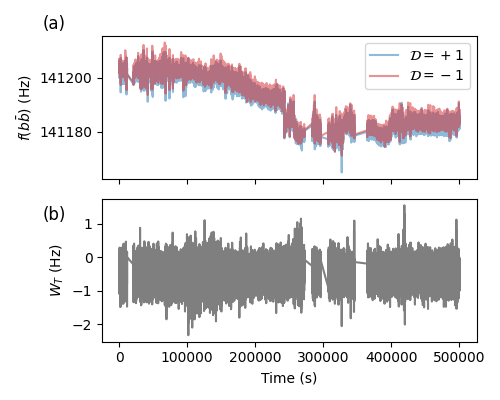

In [82]:
start_times = results[mask, col_indices["start_time"]].astype(float)
end_times = results[mask, col_indices["end_time"]].astype(float)

center_times = (start_times + end_times) / 2
center_time_offset = center_times[0]
center_time_offsetted = center_times - center_time_offset
cycle_times = end_times - start_times
num_of_cycles = len(start_times)
total_duration = end_times[-1] - start_times[0]

f_ps = unumpy.nominal_values(results[mask, col_indices["f+"]])
f_ms = unumpy.nominal_values(results[mask, col_indices["f-"]])
W_Ts = unumpy.nominal_values(results[mask, col_indices["W_T"]])

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 4))
axs[0].set_ylabel("$f(b\\bar{b})$ (Hz)")
axs[1].set_ylabel("$W_T$ (Hz)")
axs[1].set_xlabel("Time (s)")

axs[0].plot(
    center_time_offsetted,
    f_ps,
    label="$\\mathcal{D}=+1$",
    color="C0",
    alpha=0.5,
)
axs[0].plot(
    center_time_offsetted,
    f_ms,
    label="$\\mathcal{D}=-1$",
    color="C3",
    alpha=0.5,
)
axs[0].text(-0.16, 1.05, "(a)", transform=axs[0].transAxes, fontsize=12)
axs[0].legend()
axs[1].plot(
    center_time_offsetted,
    W_Ts,
    color="C7",
)
axs[1].text(-0.16, 0.85, "(b)", transform=axs[1].transAxes, fontsize=12)
plt.tight_layout()
plt.savefig("time-series.pdf")
plt.show()

In [83]:
cycle_time_avg = np.average(cycle_times)
cycle_frequency_avg = 1 / cycle_time_avg
W_T_unc = np.std(W_Ts) / np.sqrt(num_of_cycles)

print(f'#{first} - #{last}')
print(f"Time: {total_duration:.1f} s, N_cycle = {num_of_cycles}")
print(f"Cycle time (laser unlock time not included): {np.average(cycle_times):.2f} s, cycle frequency {cycle_frequency_avg:.2f} Hz")
print("W_T =", present_float(np.average(W_T * 1e3), W_T_unc * 1e3, 2), "mHz")
print(f"W_T_unc sensitivity = {W_T_unc * 1e3 / np.sqrt(3600 / total_duration):.1f} mHz sqrt(hr)")
print(f"W_T_unc per cycle = {W_T_unc * np.sqrt(num_of_cycles):.2f} Hz")

#4787037 - #5237620
Time: 500396.1 s, N_cycle = 54675
Cycle time (laser unlock time not included): 6.84 s, cycle frequency 0.15 Hz
W_T = -507.9(1.3) mHz
W_T_unc sensitivity = 15.1 mHz sqrt(hr)
W_T_unc per cycle = 0.30 Hz


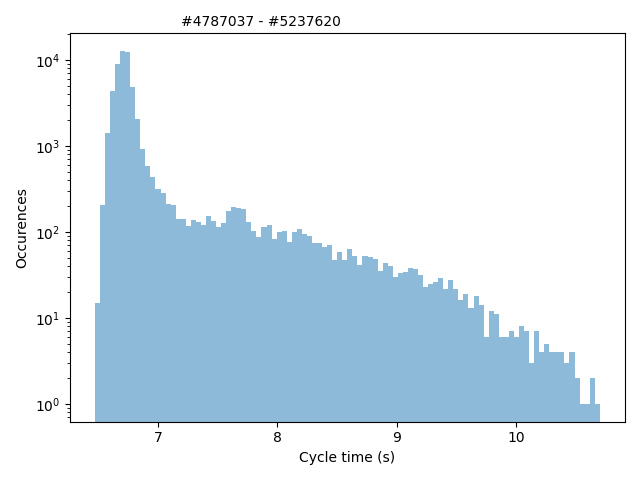

In [84]:
fig, ax = plt.subplots()
ax.text(0.2, 1.02, f'#{first} - #{last}', transform = ax.transAxes)
ax.hist(cycle_times, bins=100, alpha=0.5)
ax.set_xlabel("Cycle time (s)")
ax.set_ylabel("Occurences")
ax.set_yscale("log")
plt.tight_layout()
plt.show()

## cycle time simulation

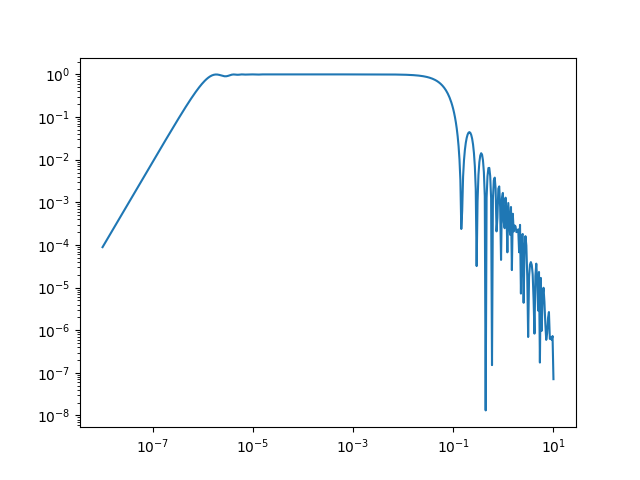

In [85]:
freqs_test = np.logspace(-8, 1, 500)
sensitivity_func = frequency_sensitivity_from_experiment_times(start_times, end_times, freqs_test)
fig, ax = plt.subplots()
ax.plot(freqs_test, sensitivity_func(freqs_test))
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

## analysis 08-12

In [86]:
ls = LombScargle(center_times, W_Ts, normalization="psd")

min_freq = 0.5 / total_duration
max_freq = 0.5 / cycle_time_avg
fs, f_W_T_psd = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
power_W_T = ls_psd_to_power_spectrum(f_W_T_psd, num_of_cycles)

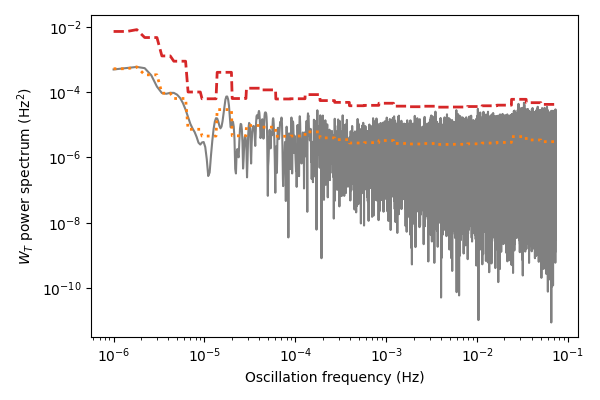

In [87]:
fs_bins = np.logspace(np.log10(np.min(fs) - 1e-10), np.log10(np.max(fs) + 1e-10), 30 + 1)
W_T_binned_indices = np.digitize(fs, fs_bins)
W_T_binned = []
for kk in range(1, len(fs_bins)):
    power_W_T_same_bin = power_W_T[W_T_binned_indices==kk]
    W_T_binned.extend([np.average(power_W_T_same_bin)] * len(power_W_T_same_bin))
W_T_binned = np.array(W_T_binned)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, power_W_T, label="data", color="gray")
ax.plot(fs, W_T_binned, label="binned average", color="C1", ls="dotted", linewidth=2)
global_95_bound = -np.log(1 - 0.95 ** (1/num_of_cycles)) * W_T_binned
ax.plot(fs, global_95_bound, label=f"95% confidence level", color="C3", linewidth=2, ls="dashed")
ax.set_ylabel("$W_T$ power spectrum (Hz$^2$)")
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.legend()
plt.tight_layout()
plt.savefig("spectrum.pdf")
plt.show()

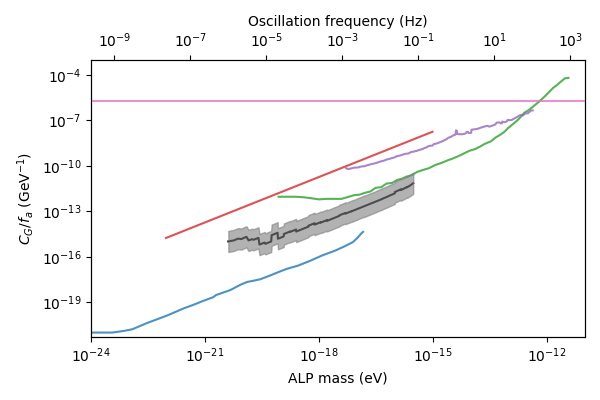

In [88]:
W_T_bound = np.sqrt(global_95_bound * 2 / sensitivity_func(fs))
theta_bound_Flambaum = theta_from_W_T(W_T_bound, S_Flambaum, E_xtl)
theta_bound_Sushkov = theta_from_W_T(W_T_bound, S_Sushkov, E_xtl)
theta_bound_geo_mean = theta_from_W_T(W_T_bound, S_geo_mean, E_xtl)

stochastic_factor = 3
inverse_fa_bound_Flambaum = inverse_fa_limit(fs, theta_bound_Flambaum) * stochastic_factor
inverse_fa_bound_Sushkov = inverse_fa_limit(fs, theta_bound_Sushkov) * stochastic_factor
inverse_fa_bound_geo_mean = inverse_fa_limit(fs, theta_bound_geo_mean) * stochastic_factor

masses = axion_frequency_to_mass(fs)
fig, ax = plt.subplots(figsize=(6, 4))
ax1 = ax.twiny()
counter = 0
for kk in best_exp_bounds:
    temp_x = best_exp_bounds[kk][0]
    temp_y = best_exp_bounds[kk][1]
    #ax.fill_between(temp_x, temp_y, 1, alpha=0.2, zorder=counter, color=f"C{counter}")
    # temp_x = np.append([temp_x[0]], temp_x)
    # temp_y = np.append([1], temp_y)
    # temp_x = np.append(temp_x, [temp_x[-1]])
    # temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.8, zorder=counter, color=f"C{counter}")
    counter += 1
    if counter == 1:
        counter += 1
for kk in worse_exp_bounds:
    temp_x = worse_exp_bounds[kk][0]
    temp_y = worse_exp_bounds[kk][1]
    #ax.fill_between(temp_x, temp_y, 1, alpha=0.2, zorder=counter, color=f"C7")
    # temp_x = np.append([temp_x[0]], temp_x)
    # temp_y = np.append([1], temp_y)
    # temp_x = np.append(temp_x, [temp_x[-1]])
    # temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.8, zorder=counter, color=f"C{counter}")
    counter += 1
    if counter == 1:
        counter += 1
for kk in model_indep_theory_bounds:
    temp_x = model_indep_theory_bounds[kk][0]
    temp_y = model_indep_theory_bounds[kk][1]
    #ax.fill_between(temp_x, temp_y, 1, alpha=0.2, zorder=counter, color=f"C6")
    # temp_x = np.append([temp_x[0]], temp_x)
    # temp_y = np.append([1], temp_y)
    # temp_x = np.append(temp_x, [temp_x[-1]])
    # temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.8, zorder=counter, color=f"C6")
    counter += 1
    if counter == 1:
        counter += 1
#ax.fill_between(masses, inverse_fa_bound_Sushkov, 1, zorder=counter, color="gray", alpha=0.6)
#ax.fill_between(masses, inverse_fa_bound_Flambaum, 1, zorder=counter, color="gray", alpha=0.6)
# ax.plot(
#     np.append(np.append(masses[0], masses), masses[-1]),
#     np.append(np.append(1, inverse_fa_bound_geo_mean), 1),
#     color="k", label="Eu:YSO (this work)", zorder=counter, alpha=1
# )
# ax.plot(
#     np.append(np.append(masses[0], masses), masses[-1]),
#     np.append(np.append(1, inverse_fa_bound_geo_mean), 1),
#     color="k", label="Eu:YSO (this work)", zorder=counter, alpha=1
# )
ax.plot(
    masses,
    inverse_fa_bound_geo_mean,
    color="k", label="Eu:YSO (this work)", zorder=counter, alpha=1
)
ax.fill_between(masses, inverse_fa_bound_Flambaum, inverse_fa_bound_Sushkov, zorder=counter, color="gray", alpha=0.6)
# ax.plot(
#     np.append(np.append(masses[0], masses), masses[-1]),
#     np.append(np.append(1, inverse_fa_bound_Flambaum), 1),
#     color="k", label="Eu:YSO (this work)", zorder=counter, alpha=1, linewidth=0.5
# )
ax.set_ylabel("$C_G / f_a$ (GeV${}^{-1}$)")
ax.set_xlabel("ALP mass (eV)")
ax1.set_xscale("log")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(0.5e-21, 1e-3)
ax.set_xticks([1e-24, 1e-21, 1e-18, 1e-15, 1e-12])
ax.set_xlim(1e-24, 1e-11)
ax1.set_xlim(axion_mass_to_frequency(1e-24), axion_mass_to_frequency(1e-11))
ax1.set_xticks([1e-9, 1e-7, 1e-5, 1e-3, 0.1, 10, 1000])
ax1.set_xlabel("Oscillation frequency (Hz)")
#ax.legend()
plt.tight_layout()
plt.savefig("exclusion.pdf")
plt.show()

## Extend to ~1.7 Hz

In [126]:
times = results[:, col_indices["start_time"]].astype(float)[mask]
W_T = unumpy.nominal_values(results[:, col_indices["W_T"]])[mask]
#W_T += np.sin(0.48 * 2 * np.pi * times) * 0.063

ls = LombScargle(times - times[0], W_T, normalization="psd")

min_freq = 0.5 / duration  # 2 times longer than the oscillation
max_freq = 15 / cycle_time_avg
fs, f_W_T_psd = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=7)
power_W_T = ls_psd_to_power_spectrum(f_W_T_psd, num_of_cycles)

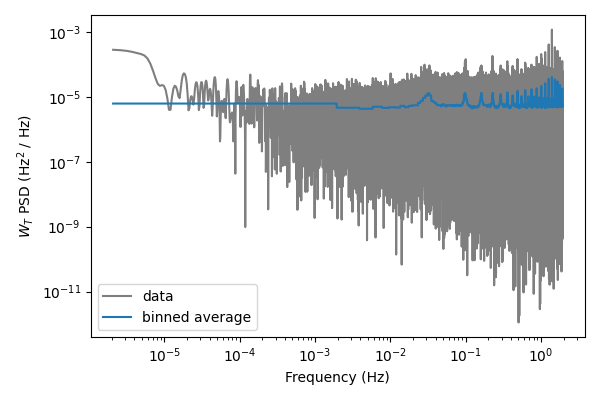

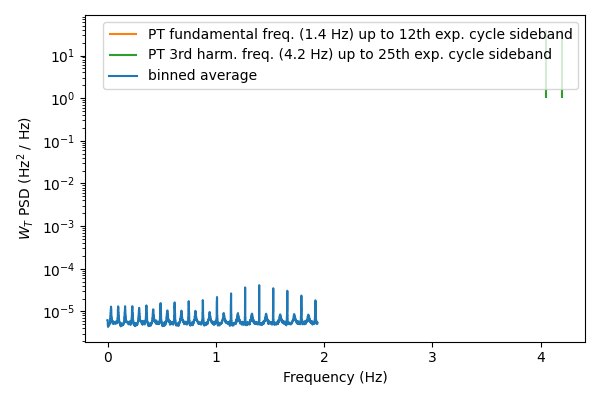

In [127]:
fs_bins = np.linspace(np.min(fs) - 1e-10, np.max(fs) + 1e-10, 1000 + 1)
W_T_binned_indices = np.digitize(fs, fs_bins)
W_T_binned = []
for kk in range(1, len(fs_bins)):
    f_W_T_psd_same_bin = power_W_T[W_T_binned_indices==kk]
    W_T_binned.extend([np.average(f_W_T_psd_same_bin)] * len(f_W_T_psd_same_bin))
W_T_binned = np.array(W_T_binned)
W_T_avg_all = np.average(power_W_T)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, power_W_T, label="data", color="C7")
ax.plot(fs, W_T_binned, label="binned average")
global_95_bound = -np.log(1 - 0.95 ** (1/len(times))) * W_T_binned
#ax.plot(fs, global_95_bound, label=f"95% confidence level", color="gray")
ax.set_ylabel("$W_T$ PSD (Hz$^2$ / Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.show()


pt_freqs = []
for kk in range(0, 20):
    for ll in [1]:
        freq = abs(kk * cycle_frequency_avg - 1.4 * ll)
        if freq < 1.6:
            pt_freqs.append(freq)
fig, ax = plt.subplots(figsize=(6, 4))

pt_freqs = []
for kk in range(0, 13):
    for ll in [1]:
        freq = abs(kk * cycle_frequency_avg - 1.4 * ll)
        if freq < 4.4 and freq > 4.0:
            pt_freqs.append(freq)
ax.vlines(pt_freqs, 1., 40, color="C1", label="PT fundamental freq. (1.4 Hz) up to 12th exp. cycle sideband")
pt_freqs = []
for kk in range(0, 26):
    for ll in [3]:
        freq = abs(kk * cycle_frequency_avg - 1.4 * ll)
        if freq < 4.4 and freq > 4.0:
            pt_freqs.append(freq)
ax.vlines(pt_freqs, 1., 40, color="C2", label="PT 3rd harm. freq. (4.2 Hz) up to 25th exp. cycle sideband")
ax.plot(fs, W_T_binned, label="binned average")
ax.set_ylabel("$W_T$ PSD (Hz$^2$ / Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_yscale("log")
ax.legend()
#ax.set_xlim(0.05, 1.5)
plt.tight_layout()
plt.show()

## Exponential distribution confirmation

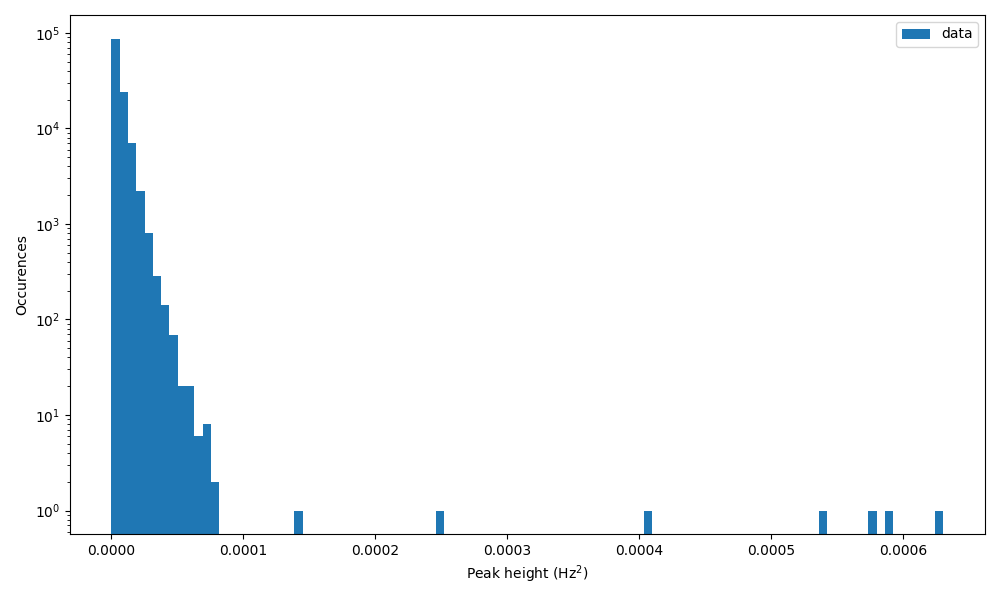

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(power_W_T, label="data", bins=100)
# filter = np.zeros(len(f_W_T_psd), dtype=bool)
# filter = ((fs < 1.40004) | (fs > 1.4003)) & ((fs < 2.534) | (fs > 2.566))
# ax.hist(f_W_T_psd[filter], label="data", bins=100)

#ax.plot([0, 0.00132], [1.8e6, 1e-2])
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("Peak height (Hz$^2$)")
ax.set_ylabel("Occurences")
plt.tight_layout()
plt.show()

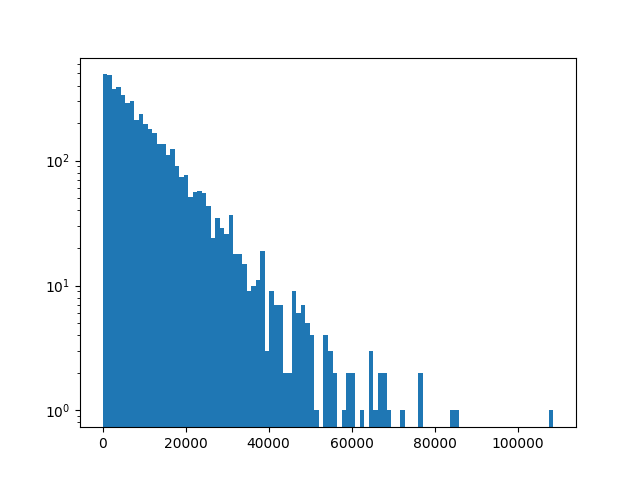

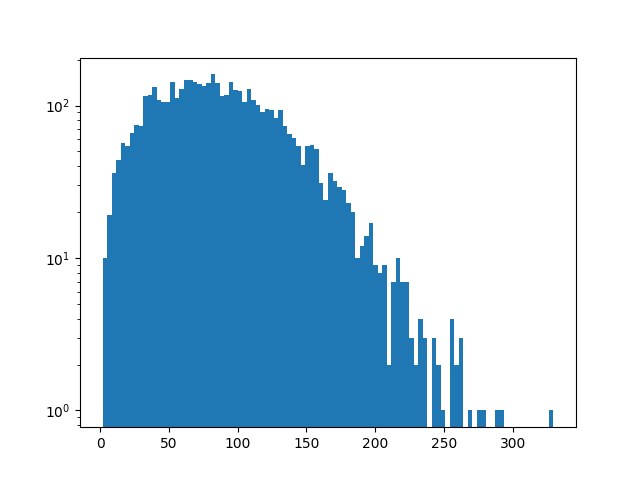

In [116]:
test_t_data = np.random.normal(size=10000)
test_ts = np.arange(len(test_t_data))
test_f_data = np.fft.rfft(test_t_data)
fig, ax = plt.subplots()
ax.hist(np.abs(test_f_data)**2, bins=100)
ax.set_yscale("log")
plt.show()
fig, ax = plt.subplots()
ax.hist(np.abs(test_f_data), bins=100)
ax.set_yscale("log")
plt.show()

## astropy 95%

0.22372892144829667
0.20540118657579093
0.22406126571548085


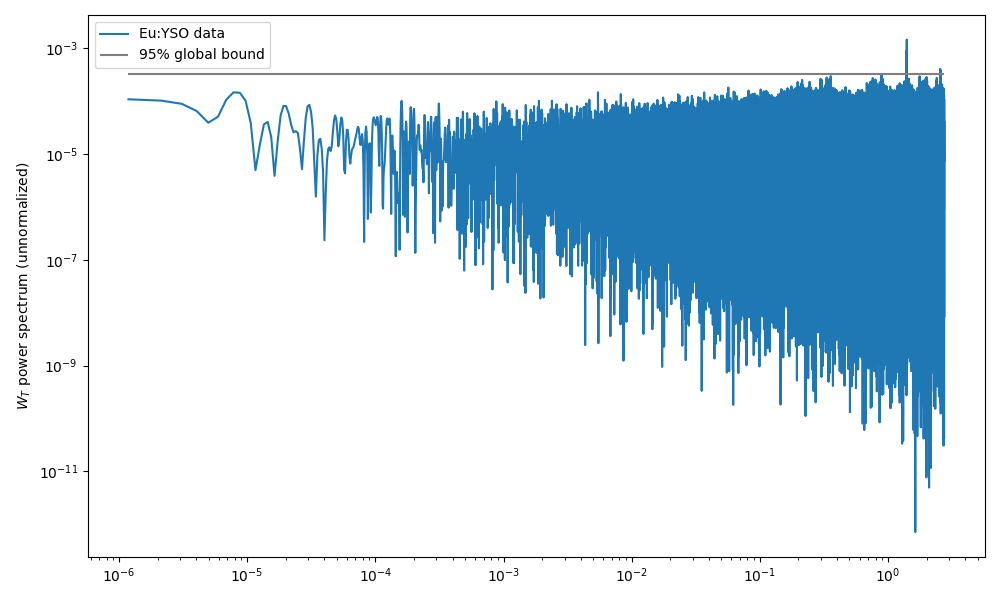

In [44]:
ls1 = LombScargle(times, W_T)

min_freq = 0.25 / duration  # 4 times longer than the oscillation
max_freq = 5 / cycle_time_avg
fs1, f_W_T_psd1 = ls1.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)

f_W_T_psd1_fal = ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq)
print(ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq, method="baluev") / np.max(f_W_T_psd1))
print(ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq, method="naive") / np.max(f_W_T_psd1))
print(ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq, method="davies") / np.max(f_W_T_psd1))
# print(ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq, method="bootstrap") / np.max(f_W_T_psd1))  # takes forever
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fs1, f_W_T_psd1, label="Eu:YSO data")
ax.hlines([f_W_T_psd1_fal], np.min(fs1), np.max(fs1), label="95% global bound", color="C7")
ax.set_ylabel("$W_T$ power spectrum (unnormalized)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.show()